In [6]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
import time
import sunode
import sunode.wrappers.as_aesara
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
import sympy as sym


In [7]:
params = {
    'alpha': (),
    'beta': (),
    'gamma': (),
    'delta': (),
}

states = {
    'hares': (),
    'lynxes': (),
}


In [8]:
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.
    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynxes * y.hares,
        'lynxes': p.delta * y.hares * y.lynxes - p.gamma * y.lynxes,
    }


In [9]:
def lotka_volterra_log(t, y, p):
    exp = np.vectorize(sym.exp)

    hares = exp(y.log_hares)
    lynxes = exp(y.log_lynxes)

    dhares = p.alpha * hares - p.beta * lynxes * hares
    dlynxes = p.delta * hares * lynxes - p.gamma * lynxes
    return { 'log_hares': dhares / hares, 'log_lynxes': dlynxes / lynxes }


problem = sunode.SympyProblem(
    params=params,
    states=states,
    rhs_sympy=lotka_volterra,
    derivative_params=()
)
solver = sunode.solver.Solver(problem,  solver='BDF')

y0 = np.zeros((), dtype=problem.state_dtype)
y0['hares'] = 1
y0['lynxes'] = 0.1

# At which time points do we want to evalue the solution
tvals = np.linspace(0, 10)

In [45]:
solver.set_params_dict({
    'alpha': 0.1,
    'beta': 0.2,
    'gamma': 0.3,
    'delta': 0.4,
})


output = solver.make_output_buffers(tvals)
solver.solve(t0=0,  y0=y0, tvals=tvals, y_out=output)

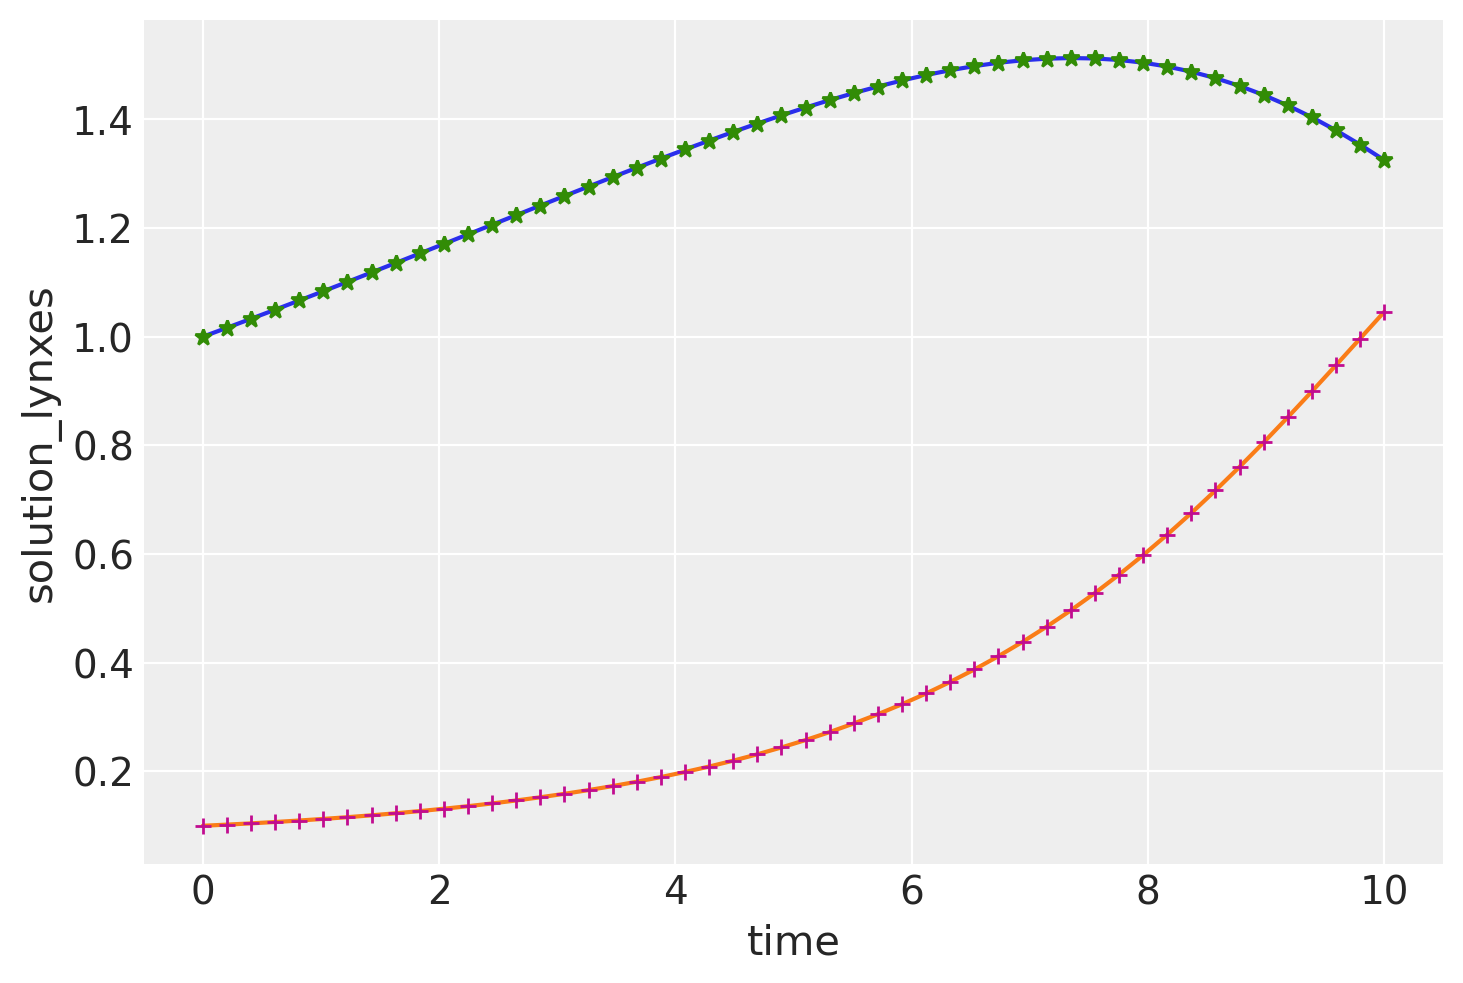

In [46]:
solver.as_xarray(tvals, output).solution_hares.plot()
solver.as_xarray(tvals, output).solution_lynxes.plot()


plt.plot(tvals, output[:,0], '*' )
plt.plot(tvals, output[:,1], '+' )

